In [1]:
!rm -r *
!git clone https://github.com/LudoRey/dip-deblur/
!mv dip-deblur/* ./
!rm -r dip-deblur

Cloning into 'dip-deblur'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 147 (delta 71), reused 97 (delta 36), pack-reused 0
Receiving objects: 100% (147/147), 3.44 MiB | 12.53 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from unet import *
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

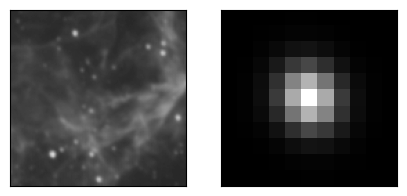

In [37]:
# Read image and PSF
im_blur_noisy = read_img('data/veil128_stretched.tif', as_tensor=True).to(device)
ker = read_img('data/veil128_psf.tif', as_tensor=True).to(device)


fig, axes = plt.subplots(1,2, figsize=(5,10))
axes[0].imshow(to_numpy(im_blur_noisy), vmin=0, vmax=1, cmap='gray')
axes[1].imshow(to_numpy(ker), cmap='gray')
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [44]:
nb_epoch = 1000
learning_rate = 0.01
input = (torch.rand(1,32,128,128)/10).to(device)
criterion = nn.MSELoss()
criterion = CsiszarDiv()

net_params = {'feature_channels' : 128, 'skip_channels' : 4, 'depth' : 4}

# Create network
model = Unet(in_channels=input.shape[1], out_channels=1, **net_params)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Optimizing loop
model.train()
for i_epoch in range(nb_epoch):
    optimizer.zero_grad()
    im_recon = model(input)
    loss = criterion(blur(im_recon, ker), im_blur_noisy)
    loss.backward()
    optimizer.step()
    if (i_epoch+1) % 100 == 0:
        print(' [-] epoch {:}/{:}, loss {:.6f}'.format(i_epoch+1, nb_epoch, loss.item()))

 [-] epoch 100/1000, loss 11.766783
 [-] epoch 200/1000, loss 2.795787
 [-] epoch 300/1000, loss 1.418362
 [-] epoch 400/1000, loss 0.952914
 [-] epoch 500/1000, loss 0.777537
 [-] epoch 600/1000, loss 0.769812
 [-] epoch 700/1000, loss 0.595328
 [-] epoch 800/1000, loss 0.535717
 [-] epoch 900/1000, loss 0.489526
 [-] epoch 1000/1000, loss 0.563163


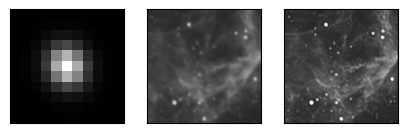

In [46]:
fig, axes = plt.subplots(1,3, figsize=(5,10))

axes[0].imshow(to_numpy(ker), cmap='gray')
axes[1].imshow(to_numpy(im_blur_noisy), vmin=0, vmax=1, cmap='gray')
axes[2].imshow(to_numpy(im_recon), vmin=0, vmax=1, cmap='gray')

for ax in axes.flatten():
  ax.tick_params(axis=u'both', which=u'both',length=0)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  
plt.show()
fig.savefig('figs/veil.png', dpi=300, bbox_inches='tight', transparent=True)

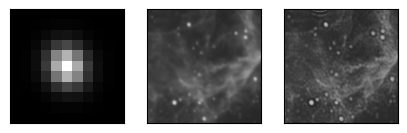

In [36]:
# For veil nebula unstretched

ref = read_img('data/veil128_stretched.tif', as_tensor=False)

fig, axes = plt.subplots(1,3, figsize=(5,10))

axes[0].imshow(to_numpy(ker), cmap='gray')
axes[1].imshow(match_hist(to_numpy(im_blur_noisy), ref), vmin=0, vmax=1, cmap='gray')
axes[2].imshow(match_hist(to_numpy(im_recon), ref), vmin=0, vmax=1, cmap='gray')

for ax in axes.flatten():
  ax.tick_params(axis=u'both', which=u'both',length=0)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  
plt.show()
#fig.savefig('figs/veil.png', dpi=300, bbox_inches='tight', transparent=True)